### This file records the results without the feature selection procedure.

In [1]:
from sklearn.decomposition import PCA
import sksurv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dimention Reduction
Selected Method: PCA

In [2]:
# read imputed data
X = pd.read_csv('selectedX.csv',index_col=0)
X.iloc[-3:,-3:]

,|D42043|*AA243583|Hs.79123|KIAA0084 protein,"||*AA805514|Hs.319447|Homo sapiens cDNA FLJ30948 fis, clone FEBRA2007900","|S69790|~W04636|Hs.82318|WAS protein family, member 3.2"
433,-0.194401,-0.104116,1.758000
435,0.143112,0.030573,-0.041065
439,0.480200,0.092100,0.916000


In [3]:
# PCA and n_components
pca = PCA(svd_solver='full')
Xpc = pca.fit_transform(X)
print(X.shape)
print(Xpc.shape)

(240, 380)
(240, 240)


**Results from the PCA analysis in R codes:**

In [4]:
p2n = {0.3:4,0.5:13,0.7:34,0.8:54,0.9:91,0.95:124,0.99:184}
pd.DataFrame({'Cum Var':list(p2n.keys()),'n_components':list(p2n.values())},index=range(len(p2n)))

,Cum Var,n_components
0,0.30,4
1,0.50,13
2,0.70,34
3,0.80,54
4,0.90,91
5,0.95,124
6,0.99,184


In [5]:
# Read time and status
Y = pd.read_csv('Patient_data_NEJM.csv', index_col=0)
Y = Y.sort_index()
assert all(Y.index==X.index) # make sure that the index is the same
Y['GMgroup'] = pd.read_csv('GaussianMixtureResult.csv').as_matrix().reshape([-1]) # the group of Gaussian Mixture model
Y.head(3)

,Analysis Set,Follow-up (years),Status at follow-up,Subgroup,IPI Group,Germinal center B cell signature,Lymph node signature,Proliferation signature,BMP6,MHC class II signature,Outcome predictor score,GMgroup
DLBCL sample (LYM number),,,,,,,,,,,,
1,Validation,11.0,Dead,Type III,Medium,-0.35,0.50,-0.22,-1.29,-0.56,-0.30,1
2,Training,4.0,Alive,GCB,Low,0.28,-0.07,-0.56,0.46,0.57,-0.23,0
3,Validation,10.6,Dead,GCB,High,1.02,1.15,-0.31,-0.14,-0.05,-0.68,0


In [6]:
event = Y['Status at follow-up']=='Dead'
time = Y['Follow-up (years)'].replace(0,0.01)

# Basic Survival Analysis

#### KM Curve

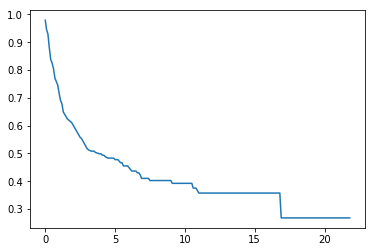

In [7]:
from sksurv.nonparametric import kaplan_meier_estimator
KMest = kaplan_meier_estimator(event, time)
plt.plot(*KMest)

(0, 1)

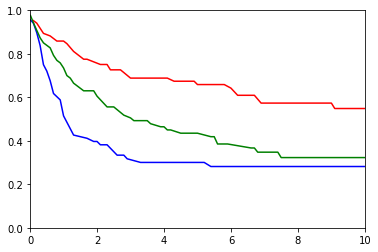

In [8]:
plt.plot(*sksurv.nonparametric.kaplan_meier_estimator(event[Y['GMgroup']==0], time[Y['GMgroup']==0]),c='r')
plt.plot(*sksurv.nonparametric.kaplan_meier_estimator(event[Y['GMgroup']==1], time[Y['GMgroup']==1]),c='b')
plt.plot(*sksurv.nonparametric.kaplan_meier_estimator(event[Y['GMgroup']==2], time[Y['GMgroup']==2]),c='g')
plt.xlim([0,10])
plt.ylim([0,1])

(0, 1)

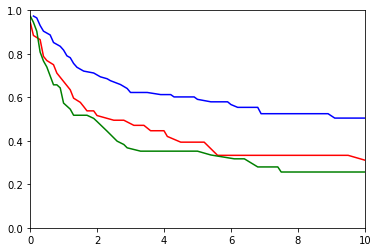

In [9]:
plt.plot(*sksurv.nonparametric.kaplan_meier_estimator(event[Y['Subgroup']=='Type III'], time[Y['Subgroup']=='Type III']),c='r')
plt.plot(*sksurv.nonparametric.kaplan_meier_estimator(event[Y['Subgroup']=='GCB'], time[Y['Subgroup']=='GCB']),c='b')
plt.plot(*sksurv.nonparametric.kaplan_meier_estimator(event[Y['Subgroup']=='ABC'], time[Y['Subgroup']=='ABC']),c='g')
plt.xlim([0,10])
plt.ylim([0,1])

#### nelson_aalen Curve

(0, 1.5)

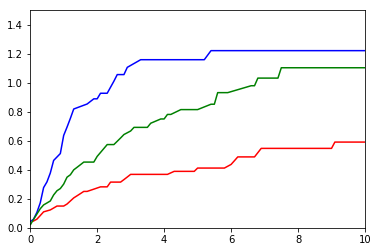

In [10]:
plt.plot(*sksurv.nonparametric.nelson_aalen_estimator(event[Y['GMgroup']==0], time[Y['GMgroup']==0]),c='r')
plt.plot(*sksurv.nonparametric.nelson_aalen_estimator(event[Y['GMgroup']==1], time[Y['GMgroup']==1]),c='b')
plt.plot(*sksurv.nonparametric.nelson_aalen_estimator(event[Y['GMgroup']==2], time[Y['GMgroup']==2]),c='g')
plt.xlim([0,10])
plt.ylim([0,1.5])

(0, 1.5)

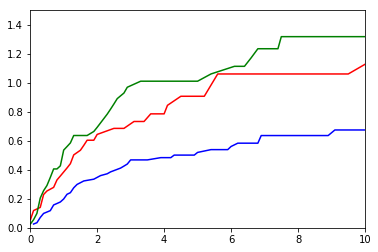

In [11]:
plt.plot(*sksurv.nonparametric.nelson_aalen_estimator(event[Y['Subgroup']=='Type III'], time[Y['Subgroup']=='Type III']),c='r')
plt.plot(*sksurv.nonparametric.nelson_aalen_estimator(event[Y['Subgroup']=='GCB'], time[Y['Subgroup']=='GCB']),c='b')
plt.plot(*sksurv.nonparametric.nelson_aalen_estimator(event[Y['Subgroup']=='ABC'], time[Y['Subgroup']=='ABC']),c='g')
plt.xlim([0,10])
plt.ylim([0,1.5])

# Survival Machine Learning Models
### A complete Search CV on different models, different data, and different parameters:

In [12]:
# define the CV tools
from sklearn.model_selection import GridSearchCV
def tune_model(model,x,y,param_grid):
    '''given the model and param_grid, return the GridSearchCV fitted class'''
    gscv = GridSearchCV(model,param_grid, n_jobs=3,refit=False,error_score=-1)
    gscv.fit(x,y)
    return gscv.__dict__ # only return the info dict from the class
def tune_data(model,y,param_grid,p2n):
    '''given the model and param_grid, on each data (by p2n), return the set of CV results'''
    result = {}
    for p in p2n:
        print('   Tuning p=',p)
        Xnew = Xpc[:,:p2n[p]]
        result[p] = tune_model(model,Xnew,y,param_grid)
    print('   Tuning original data')
    result[0] = tune_model(model,X,y,param_grid)
    print('   Tuning p=1')
    result[1] = tune_model(model,Xpc,y,param_grid)
    return result
def tune_all_models(model_list,y,p2n):
    '''given models and their corresponding param_grid, return all the CV results'''
    result = {}
    for name,model,param_grid in model_list:
        print('Model:',name)
        result[name] = tune_data(model,y,param_grid,p2n)
    return result
def score_table(CVresult):
    '''given the output result, show the dataframe of the scores'''
    best = {r:{gs:CVresult[r][gs]['best_score_'] for gs in CVresult[r]} for r in CVresult}
    return pd.DataFrame(best).transpose()
def para_table(CVresult):
    '''given the output result, show the dataframe of the scores'''
    best = {r:{gs:CVresult[r][gs]['best_params_'] for gs in CVresult[r]} for r in CVresult}
    return pd.DataFrame(best).transpose()

In [13]:
# construct Y (structured)
structured = np.array([i for i in zip(event,time)],dtype=[('event',np.bool), ('time', np.float)])
structured[:3]

array([( True,  11. ), (False,   4. ), ( True,  10.6)],
      dtype=[('event', '?'), ('time', '<f8')])

#### CV fitting on ensemble models

In [14]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis,ComponentwiseGradientBoostingSurvivalAnalysis
model_list = [
    ('GradientBoostingSurvivalAnalysis',GradientBoostingSurvivalAnalysis(),{'learning_rate':[0.01,0.1],
                                                                            'max_depth':[3,4,5],
                                                                           'dropout_rate':[0,0.1]}),
    ('ComponentwiseGradientBoostingSurvivalAnalysis',ComponentwiseGradientBoostingSurvivalAnalysis(),{'learning_rate':[0.01,0.1],
                                                                           'dropout_rate':[0,0.1]})
]
CVresult_ens = tune_all_models(model_list,structured,p2n)

Model: GradientBoostingSurvivalAnalysis
   Tuning p= 0.3
   Tuning p= 0.5
   Tuning p= 0.7
   Tuning p= 0.8
   Tuning p= 0.9
   Tuning p= 0.95
   Tuning p= 0.99
   Tuning original data
   Tuning p=1
Model: ComponentwiseGradientBoostingSurvivalAnalysis
   Tuning p= 0.3
   Tuning p= 0.5
   Tuning p= 0.7
   Tuning p= 0.8
   Tuning p= 0.9
   Tuning p= 0.95
   Tuning p= 0.99
   Tuning original data
   Tuning p=1


#### CV fitting on SVM models

In [15]:
from sksurv.svm import FastSurvivalSVM, FastKernelSurvivalSVM,MinlipSurvivalAnalysis
model_list = [
    ('FastKernelSurvivalSVM',FastKernelSurvivalSVM(max_iter=200),{'alpha':[0.5,1,2],
                                                      'rank_ratio':[0,0.5,1],
                                                      'kernel':['poly','rbf']}),
    ('FastSurvivalSVM',FastSurvivalSVM(max_iter=100),{'alpha':[0.5,1,2],
                                          'rank_ratio':[0,0.5,1]}),
    ('MinlipSurvivalAnalysis',MinlipSurvivalAnalysis(),{'alpha':[0.5,1,2],
                                                      'kernel':['poly','rbf']})
]
CVresult_svm = tune_all_models(model_list,structured,p2n)

Model: FastKernelSurvivalSVM
   Tuning p= 0.3
   Tuning p= 0.5
   Tuning p= 0.7
   Tuning p= 0.8
   Tuning p= 0.9
   Tuning p= 0.95
   Tuning p= 0.99
   Tuning original data
   Tuning p=1
Model: FastSurvivalSVM
   Tuning p= 0.3
   Tuning p= 0.5
   Tuning p= 0.7
   Tuning p= 0.8
   Tuning p= 0.9
   Tuning p= 0.95
   Tuning p= 0.99
   Tuning original data
   Tuning p=1
Model: MinlipSurvivalAnalysis
   Tuning p= 0.3
   Tuning p= 0.5
   Tuning p= 0.7
   Tuning p= 0.8
   Tuning p= 0.9
   Tuning p= 0.95
   Tuning p= 0.99
   Tuning original data
   Tuning p=1


#### CV fitting on linear models

In [16]:
from sksurv.linear_model import CoxPHSurvivalAnalysis,IPCRidge
model_list = [
    ('CoxPHSurvivalAnalysis',CoxPHSurvivalAnalysis(),{'alpha':[0.5,1,2]}),
    ('IPCRidge',IPCRidge(),{'alpha':[0.5,1,1.5,2]})
]
CVresult_linear = tune_all_models(model_list,structured,p2n)

Model: CoxPHSurvivalAnalysis
   Tuning p= 0.3
   Tuning p= 0.5
   Tuning p= 0.7
   Tuning p= 0.8
   Tuning p= 0.9
   Tuning p= 0.95
   Tuning p= 0.99
   Tuning original data
   Tuning p=1
Model: IPCRidge
   Tuning p= 0.3
   Tuning p= 0.5
   Tuning p= 0.7
   Tuning p= 0.8
   Tuning p= 0.9
   Tuning p= 0.95
   Tuning p= 0.99
   Tuning original data
   Tuning p=1


### Sumary

In [17]:
CVresult = {}
CVresult.update(CVresult_linear)
CVresult.update(CVresult_ens)
CVresult.update(CVresult_svm)
pd.io.pickle.to_pickle(CVresult,'CVresults.pickle')

In [28]:
df=score_table(CVresult)

In [29]:
# sort models by max scores
df.loc[df.max(axis=1).sort_values(ascending=False).index,:]

,0.0,0.3,0.5,0.7,0.8,0.9,0.95,0.99,1.0
FastKernelSurvivalSVM,0.739841,0.647235,0.617846,0.642301,0.683080,0.708873,0.708632,0.724754,0.731105
CoxPHSurvivalAnalysis,0.738218,0.651077,0.674471,0.719204,0.712414,0.656172,0.690163,0.723613,0.738218
FastSurvivalSVM,0.729154,0.650921,0.686643,0.711296,0.725603,0.618656,0.649572,0.704779,0.733400
MinlipSurvivalAnalysis,0.728855,0.550440,0.615941,0.669204,0.702991,0.711958,0.719925,0.730735,0.732069
GradientBoostingSurvivalAnalysis,0.688807,0.585837,0.613872,0.643698,0.618914,0.614167,0.582384,0.566414,0.566351
ComponentwiseGradientBoostingSurvivalAnalysis,0.677556,0.655657,0.660375,0.681832,0.680224,0.653303,0.650361,0.655697,0.652315
IPCRidge,0.349674,0.398402,0.342454,0.322100,0.362503,0.456892,0.408495,0.347798,0.349674


In [41]:
# best parameters
best_para = para_table(CVresult).loc['FastKernelSurvivalSVM',0]
best_para

{'alpha': 0.5, 'kernel': 'rbf', 'rank_ratio': 1}

# Final Model and Validation / Prediction results

In [38]:
# train / test sets
train_flag = Y['Analysis Set']=='Training'
Xtrain = X.loc[train_flag,]
Xtest = X.loc[~train_flag,]
ytrain = structured[train_flag]
ytest = structured[~train_flag]

In [104]:
# train
KSSVM = FastKernelSurvivalSVM(**best_para)
KSSVM.fit(Xtrain,ytrain)

FastKernelSurvivalSVM(alpha=0.5, coef0=1, degree=3, fit_intercept=False,
           gamma=None, kernel='rbf', kernel_params=None, max_iter=20,
           optimizer='rbtree', random_state=None, rank_ratio=1,
           timeit=False, tol=None, verbose=False)

In [106]:
# scores
print('Training score:',KSSVM.score(Xtrain,ytrain))
print('Test score:',KSSVM.score(Xtest,ytest))

Training score: 0.997474481743
Test score: 0.72480620155


In [107]:
# predictions
pre = KSSVM.predict(Xtest)

## The model in the Paper

In [123]:
# data in the paper
Xpaper = Y.iloc[:,5:10]
Xpaper_train = Xpaper.loc[train_flag,]
Xpaper_test = Xpaper.loc[~train_flag,]

In [124]:
# restore the final model in the paper
fit_paper_final = CoxPHSurvivalAnalysis()
fit_paper_final.fit(Xpaper, structured)
pd.Series(fit_paper.coef_,index=Xpaper.columns)

Germinal center B cell signature   -0.289264
Lymph node signature               -0.242683
Proliferation signature             0.236291
BMP6                                0.306590
MHC class II signature             -0.302203
dtype: float64

In [127]:
# scores of the model （trained by training set)
from sksurv.metrics import concordance_index_censored
fit_paper = CoxPHSurvivalAnalysis()
fit_paper.fit(Xpaper_train, ytrain)
print('Paper Training score:',fit_paper.score(Xpaper_train,ytrain))
print('Paper Test score:',fit_paper.score(Xpaper_test,ytest))

Paper Training score: 0.707355571925
Paper Test score: 0.663178294574


In [140]:
# cross validation
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
cv_results = []
for i in range(100):
    Xpaper_new,ypaper_new = shuffle(Xpaper,structured)
    cv_paper = cross_val_score(CoxPHSurvivalAnalysis(),Xpaper_new,ypaper_new,cv=3)
    cv_results.append(cv_paper.mean())
    if i%5==0: print(i)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [142]:
print('Paper CV score:',np.mean(cv_results))

Paper CV score: 0.679456197179
